# Sprint 2: 

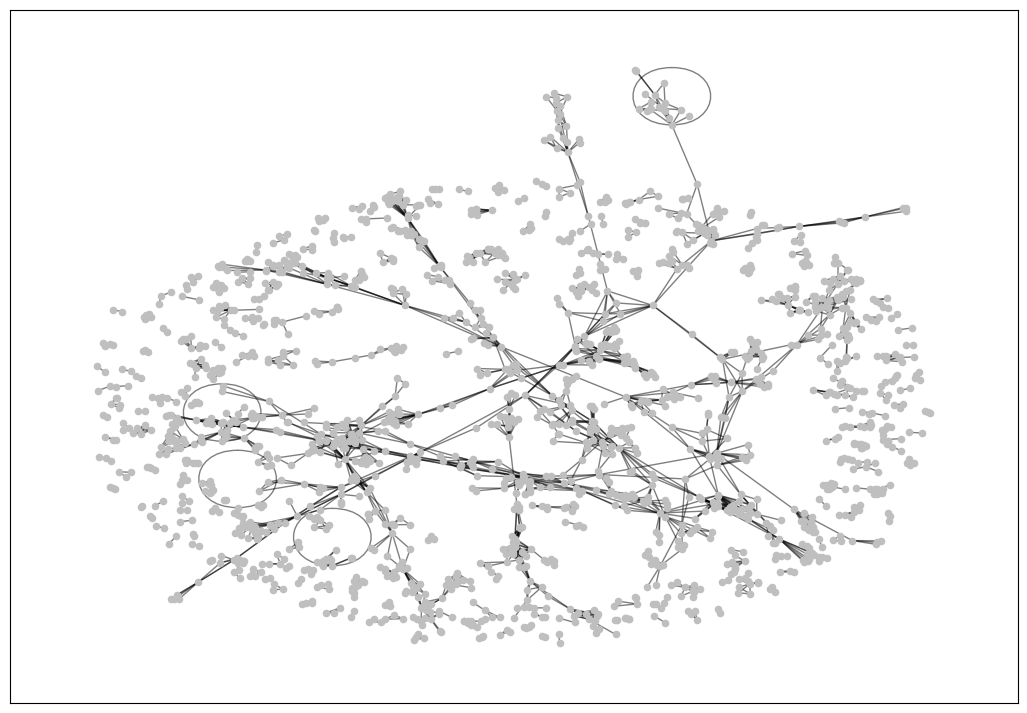

d:\Iker MEGA\Uni\2025-26\Primer Cuatrimestre\HB\Códigos\cdp-proyecto\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import import_ipynb
import CDP_0_SRC
import random
import math
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import logging
from optuna.visualization import plot_optimization_history, plot_slice

In [2]:
def modularidad(G, partition, weight='weight'):
    """
    Cálculo vectorizado y correcto de Q.
    Q = Sum_c [ (Lc/m) - (dc/2m)^2 ]
    Donde:
    - Lc: Suma de pesos de enlaces DENTRO de la comunidad c
    - dc: Suma de grados de los nodos en la comunidad c
    """
    m = G.size(weight=weight)
    if m == 0: return 0
    
    # 1. Calcular suma de grados por comunidad (dc)
    community_degrees = {}
    for node, deg in G.degree(weight=weight):
        comm = partition.get(node)
        if comm is not None:
            community_degrees[comm] = community_degrees.get(comm, 0.0) + deg
            
    # 2. Calcular suma de pesos internos por comunidad (Lc)
    community_internal_weights = {}
    # Iteramos solo aristas existentes (eficiente)
    for u, v, data in G.edges(data=True):
        comm_u = partition.get(u)
        comm_v = partition.get(v)
        if comm_u is not None and comm_u == comm_v:
            w = data.get(weight, 1.0)
            community_internal_weights[comm_u] = community_internal_weights.get(comm_u, 0.0) + w
            
    # 3. Aplicar fórmula sumatoria (Mucho más rápido que iterar pares)
    Q = 0.0
    for comm in community_degrees:
        Lc = community_internal_weights.get(comm, 0.0) # Pesos internos
        dc = community_degrees[comm]                   # Grados totales
        
        term1 = Lc / m
        term2 = (dc / (2 * m)) ** 2
        
        Q += term1 - term2
        
    return Q

def generate_random_partition_with_all_nodes(G, k):
    partition = {node: np.random.randint(1, k+1) for node in G.nodes()}
    return partition

def generate_random_move_neighbors(partition, k, num_vecinos):
    """
    Genera una lista de 'num_vecinos' particiones ÚNICAS.
    Evita devolver candidatos repetidos.
    """
    neighbors = []
    nodes = list(partition.keys())
    
    moves_set = set()
    
    max_possible_moves = len(nodes) * (k - 1)
    target_count = min(num_vecinos, max_possible_moves)
    
    while len(moves_set) < target_count:
        u = random.choice(nodes)
        current_comm = partition[u]
        
        possible_communities = [c for c in range(1, k+1) if c != current_comm]
        
        if possible_communities:
            new_comm = random.choice(possible_communities)
            
            moves_set.add((u, new_comm))

    for u, new_comm in moves_set:
        new_partition = partition.copy()
        new_partition[u] = new_comm
        neighbors.append(new_partition)
        
    return neighbors

def random_search(G, k, evals):
    """
    Algoritmo de búsqueda aleatoria (Baseline).
    Genera soluciones al azar y se queda con la mejor.
    """
    best_fit = -float('inf')
    
    for _ in range(evals):
        part = generate_random_partition_with_all_nodes(G, k)
        fit = modularidad(G, part)
        if fit > best_fit:
            best_fit = fit
            
    return best_fit

In [3]:
class FastModularity:
    def __init__(self, G):
        self.G = G
        self.m = G.size(weight='weight')
        self.node_degrees = dict(G.degree(weight='weight'))
        self.nodes = list(G.nodes())
        self.two_m = 2 * self.m
        
    def calculate_from_scratch(self, partition):
        """Calcula Q inicial y prepara estructuras auxiliares."""
        # Suma de grados de nodos en cada comunidad
        self.comm_degrees = {} 
        for node, comm in partition.items():
            deg = self.node_degrees[node]
            self.comm_degrees[comm] = self.comm_degrees.get(comm, 0.0) + deg
            
        return modularidad(self.G, partition)

    def get_delta_Q(self, node, old_comm, new_comm, partition):
        """
        Calcula variacion de modularidad al mover 'node' de 'old_comm' a 'new_comm'.
        NO actualiza las estructuras, solo calcula.
        """
        ki = self.node_degrees[node]
        k_i_in_old = 0.0
        k_i_in_new = 0.0
        
        for neighbor in self.G.neighbors(node):
            if neighbor == node: continue
            nbr_comm = partition[neighbor]
            w = self.G[node][neighbor].get('weight', 1.0)
            
            if nbr_comm == old_comm:
                k_i_in_old += w
            elif nbr_comm == new_comm:
                k_i_in_new += w
        
        tot_old = self.comm_degrees.get(old_comm, 0.0)
        tot_new = self.comm_degrees.get(new_comm, 0.0)
        delta_remove = - (k_i_in_old / self.m) + (2 * ki * (tot_old - ki) / (self.two_m ** 2)) 
        delta_add = (k_i_in_new / self.m) - (2 * ki * tot_new / (self.two_m ** 2))
        
        return delta_add + delta_remove

    def update_state(self, node, old_comm, new_comm):
        """Actualiza las estructuras internas tras un movimiento aceptado."""
        ki = self.node_degrees[node]
        self.comm_degrees[old_comm] -= ki
        self.comm_degrees[new_comm] = self.comm_degrees.get(new_comm, 0.0) + ki

In [4]:
def randomized_constructive_greedy(G, k, fast_mod):
    """
    Construye una partición asignando nodos uno a uno a la comunidad que más aporte.
    Estocástico: El orden de los nodos es aleatorio.
    """
    nodes = list(G.nodes())
    random.shuffle(nodes) # Estocasticidad 1: Orden aleatorio
    
    # Inicializar: k nodos aleatorios a k comunidades distintas para asegurar k comunidades
    partition = {}
    used_nodes = set()
    
    # Pre-asignar semillas
    for i in range(1, k+1):
        if i <= len(nodes):
            node = nodes[i-1]
            partition[node] = i
            used_nodes.add(node)
            # Actualizar estado de FastModularity (simulado)
            fast_mod.comm_degrees[i] = fast_mod.comm_degrees.get(i, 0) + fast_mod.node_degrees[node]

    # Asignar el resto
    remaining_nodes = [n for n in nodes if n not in used_nodes]
    
    for node in remaining_nodes:
        best_comm = random.randint(1, k)
        best_delta = -float('inf')
        for c in range(1, k+1):
            # Calcular ganancia de entrar a c
            k_i_in = 0
            for nbr in G.neighbors(node):
                if nbr in partition and partition[nbr] == c:
                    k_i_in += G[node][nbr].get('weight', 1.0)
            
            tot_c = fast_mod.comm_degrees.get(c, 0.0)
            ki = fast_mod.node_degrees[node]
            delta = (k_i_in / fast_mod.m) - (ki * tot_c / (fast_mod.m * 2 * fast_mod.m)) # Aprox
            
            if delta > best_delta:
                best_delta = delta
                best_comm = c
        
        partition[node] = best_comm
        fast_mod.comm_degrees[best_comm] = fast_mod.comm_degrees.get(best_comm, 0) + fast_mod.node_degrees[node]
        
    return partition, modularidad(G, partition)

In [5]:
def simulated_annealing_optimized(G, k, max_evals, initial_temp, alpha):
    # Inicialización aleatoria
    current_partition = generate_random_partition_with_all_nodes(G, k)
    
    # Inicializar FastModularity
    fm = FastModularity(G)
    current_fitness = fm.calculate_from_scratch(current_partition)
    
    best_partition = current_partition.copy()
    best_fitness = current_fitness
    
    temp = initial_temp
    nodes = list(G.nodes())
    
    for _ in range(max_evals):
        node = random.choice(nodes)
        old_comm = current_partition[node]
        possible = [c for c in range(1, k+1) if c != old_comm]
        if not possible:
            continue
        new_comm = random.choice(possible)
        delta = fm.get_delta_Q(node, old_comm, new_comm, current_partition)
        accept = False
        if delta > 0:
            accept = True
        else:
            try:
                prob = math.exp(delta / temp)
            except OverflowError:
                prob = 0
            if random.random() < prob:
                accept = True
        
        if accept:
            current_partition[node] = new_comm
            current_fitness += delta
            fm.update_state(node, old_comm, new_comm)
            
            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_partition = current_partition.copy()
        
        temp *= alpha
        if temp < 1e-6: temp = initial_temp * 0.1 
            
    return best_partition, best_fitness

In [6]:
def genetic_algorithm_optimized(G, k, pop_size, max_evals, mutation_rate):
    generations = max_evals // pop_size
    population = [generate_random_partition_with_all_nodes(G, k) for _ in range(pop_size)]
    fitnesses = [modularidad(G, p) for p in population]
    best_overall_fit = max(fitnesses)
    for gen in range(generations):
        new_population = []
        
        # Elitismo (Guardar el mejor)
        idx_best = np.argmax(fitnesses)
        new_population.append(population[idx_best].copy())
        
        while len(new_population) < pop_size:
            # Torneo binario
            def tournament():
                i1, i2 = random.sample(range(pop_size), 2)
                return population[i1] if fitnesses[i1] > fitnesses[i2] else population[i2]
            
            p1 = tournament()
            p2 = tournament()
            child = {}
            for node in G.nodes():
                child[node] = p1[node] if random.random() < 0.5 else p2[node]
            
            # Mutación
            if random.random() < mutation_rate:
                node_mut = random.choice(list(G.nodes()))
                child[node_mut] = random.randint(1, k)
            
            new_population.append(child)
        
        population = new_population
        fitnesses = [modularidad(G, p) for p in population]
        
        current_best = max(fitnesses)
        if current_best > best_overall_fit:
            best_overall_fit = current_best
            
    return None, best_overall_fit

In [7]:
# --- 0. CARGA DE DATOS ---
print("Cargando datos y generando grafo...")
df = CDP_0_SRC.get_dataframe()
G = CDP_0_SRC.crear_grafo(df)

# --- 1. CONFIGURACIÓN OPTUNA ---
optuna.logging.set_verbosity(optuna.logging.WARNING)

def calibrar_sa(G, k_calib, n_trials=20):
    """
    Calibra SA, guarda en BD para Dashboard y muestra gráficos.
    """
    print(f"--- Calibrando SA para k={k_calib} ---")
    
    def objective(trial):
        # 1. Parámetros
        init_temp = trial.suggest_float("initial_temp", 0.1, 10.0)
        alpha = trial.suggest_float("alpha", 0.80, 0.9999)
        
        # 2. Ejecutar (versión rápida 2000 evals)
        _, fitness = simulated_annealing_optimized(
            G, k=k_calib, max_evals=2000, 
            initial_temp=init_temp, alpha=alpha
        )
        return fitness

    # 3. Crear estudio CON ALMACENAMIENTO
    study = optuna.create_study(
        direction="maximize",
        storage="sqlite:///calibracion_cdp.db",  # Archivo BD
        study_name="calibracion_sa",            # Nombre único
        load_if_exists=True                     # Continuar si existe
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    # 4. Visualización en Notebook
    print("Generando gráficos interactivos de SA...")
    try:
        fig1 = plot_optimization_history(study)
        fig1.show()
        fig2 = plot_slice(study)
        fig2.show()
    except Exception as e:
        print(f"No se pudieron generar gráficos interactivos: {e}")

    print(f"Mejores params SA: {study.best_params} -> Fit: {study.best_value:.4f}")
    return study.best_params

def calibrar_ga(G, k_calib, n_trials=20):
    """
    Calibra GA, guarda en BD para Dashboard.
    """
    print(f"--- Calibrando GA para k={k_calib} ---")
    
    def objective(trial):
        mutation_rate = trial.suggest_float("mutation_rate", 0.01, 0.5)
        
        _, fitness = genetic_algorithm_optimized(
            G, k=k_calib, pop_size=30, max_evals=2000, 
            mutation_rate=mutation_rate
        )
        return fitness

    # Crear estudio CON ALMACENAMIENTO
    study = optuna.create_study(
        direction="maximize",
        storage="sqlite:///calibracion_cdp.db",
        study_name="calibracion_ga",
        load_if_exists=True
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    # Visualización simple GA
    try:
        fig = plot_optimization_history(study)
        fig.show()
    except: pass
    
    print(f"Mejores params GA: {study.best_params} -> Fit: {study.best_value:.4f}")
    return study.best_params

# --- 2. EJECUCIÓN DE CALIBRACIÓN ---
k_calibracion = 10 

# Borrar estudios previos si quieres empezar de cero
# optuna.delete_study(study_name="calibracion_sa", storage="sqlite:///calibracion_cdp.db")
# optuna.delete_study(study_name="calibracion_ga", storage="sqlite:///calibracion_cdp.db")

print(">>> INICIANDO CALIBRACIÓN <<<")
best_params_sa = calibrar_sa(G, k_calib=k_calibracion, n_trials=20)
best_params_ga = calibrar_ga(G, k_calib=k_calibracion, n_trials=20)


# --- 3. EXPERIMENTACIÓN FINAL ---
k_values = [2, 5, 10, 20, 50, 100] 
n_reps = 5 
max_evals = 100000 # 10^5 evals completo

results_data = []

print("\n>>> INICIANDO EXPERIMENTO FINAL <<<")

for k in k_values:
    print(f"--- Ejecurando para K={k} ---")
    for rep in range(n_reps):
        
        # A. Random Search
        start = time.time()
        rs_fit = random_search(G, k, max_evals)
        results_data.append({'Algorithm': 'Random Search', 'k': k, 'Fitness': rs_fit, 'Time': time.time()-start})
        
        # B. Constructive
        start = time.time()
        fm_const = FastModularity(G)
        fm_const.calculate_from_scratch({n:1 for n in G.nodes()})
        _, const_fit = randomized_constructive_greedy(G, k, fm_const)
        results_data.append({'Algorithm': 'Constructive', 'k': k, 'Fitness': const_fit, 'Time': time.time()-start})
        
        # C. Simulated Annealing
        start = time.time()
        _, sa_fit = simulated_annealing_optimized(
            G, k, max_evals, 
            initial_temp=best_params_sa["initial_temp"], 
            alpha=best_params_sa["alpha"]
        )
        results_data.append({'Algorithm': 'SA', 'k': k, 'Fitness': sa_fit, 'Time': time.time()-start})
        
        # D. Genetic Algorithm
        start = time.time()
        _, ga_fit = genetic_algorithm_optimized(
            G, k, 
            pop_size=50, 
            max_evals=max_evals, 
            mutation_rate=best_params_ga["mutation_rate"]
        )
        results_data.append({'Algorithm': 'GA', 'k': k, 'Fitness': ga_fit, 'Time': time.time()-start})

# --- 4. VISUALIZACIÓN FINAL ---
df_res = pd.DataFrame(results_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_res, x='k', y='Fitness', hue='Algorithm', marker='o')
plt.title('Comparación de Algoritmos (Modularidad vs K)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_res, x='Algorithm', y='Fitness')
plt.title('Distribución de Fitness por Algoritmo')
plt.show()

# Para ver resultados:
# 1- Instalar optuna-dashboard (py -m pip install optuna-dashboard)
# 2- Ejecutar código del notebook
# 3- Escribir [optuna-dashboard sqlite:///calibracion_cdp.db] en la terminal
# 4- Abrir el localhost que marque y ver resultados

Cargando datos y generando grafo...
>>> INICIANDO CALIBRACIÓN <<<
--- Calibrando SA para k=10 ---
Generando gráficos interactivos de SA...


Mejores params SA: {'initial_temp': 5.9553213982084765, 'alpha': 0.9222444586494368} -> Fit: 0.0572
--- Calibrando GA para k=10 ---


[W 2026-01-18 11:50:12,339] Trial 1 failed with parameters: {'mutation_rate': 0.12932370362042772} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Iker MEGA\Uni\2025-26\Primer Cuatrimestre\HB\Códigos\cdp-proyecto\.venv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ikerg\AppData\Local\Temp\ipykernel_12384\3373775039.py", line 59, in objective
    _, fitness = genetic_algorithm_optimized(
                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        G, k=k_calib, pop_size=30, max_evals=2000,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        mutation_rate=mutation_rate
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\ikerg\AppData\Local\Temp\ipykernel_12384\2524477019.py", line 33, in genetic_algorithm_optimized
    fitnesses = [modularidad(G, p) for p in population]
                 ~~~~~~~~~~~^^^^^^
  File "C:\Users\ikerg\AppData\Local\Temp\ipyke

KeyboardInterrupt: 